# 19d: Hierarchical Model by Archetype

**Goal**: Build hierarchical PyMC model where feature effects vary by hand archetype.

**Method**: 
- Define hand archetypes (control/balanced/volatile)
- Build hierarchical model: β varies by archetype
- Test if "doubles worth more in control hands"

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from pathlib import Path

from forge.analysis.utils import viz

viz.setup_notebook_style()
np.random.seed(42)
print(f"PyMC version: {pm.__version__}")
print("Ready")

PyMC version: 5.27.0
Ready


## 1. Load Data and Define Archetypes

In [2]:
# Load unified features
features_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/12b_unified_features.csv"
df = pd.read_csv(features_path)
print(f"Loaded {len(df)} hands")

Loaded 200 hands


In [3]:
# Define archetypes based on σ(V)
# Control hands: low variance (σ < 10)
# Balanced hands: medium variance (10 <= σ < 20)
# Volatile hands: high variance (σ >= 20)

def classify_archetype(sigma):
    if sigma < 10:
        return 'control'
    elif sigma < 20:
        return 'balanced'
    else:
        return 'volatile'

df['archetype'] = df['V_std'].apply(classify_archetype)

print("Archetype distribution:")
print(df['archetype'].value_counts())

# Create archetype index for PyMC
archetype_map = {'control': 0, 'balanced': 1, 'volatile': 2}
df['archetype_idx'] = df['archetype'].map(archetype_map)

print(f"\nArchetype stats:")
print(df.groupby('archetype')[['V_mean', 'V_std', 'n_doubles', 'trump_count']].mean())

Archetype distribution:
archetype
balanced    75
control     64
volatile    61
Name: count, dtype: int64

Archetype stats:
              V_mean      V_std  n_doubles  trump_count
archetype                                              
balanced   14.986667  14.723343   1.666667     1.346667
control    19.583333   5.028426   1.890625     1.343750
volatile    6.535519  26.129530   1.639344     1.262295


## 2. Pooled Model (Baseline)

In [4]:
# Pooled model (no archetype effect)
with pm.Model() as pooled_model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=20)
    beta_doubles = pm.Normal('beta_doubles', mu=5, sigma=5)
    beta_trumps = pm.Normal('beta_trumps', mu=3, sigma=5)
    sigma = pm.HalfNormal('sigma', sigma=15)
    
    # Linear model
    mu = alpha + beta_doubles * df['n_doubles'].values + beta_trumps * df['trump_count'].values
    
    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['V_mean'].values)
    
    # Sample
    trace_pooled = pm.sample(1000, tune=1000, cores=2, random_seed=42, progressbar=False)

print("Pooled model summary:")
print(az.summary(trace_pooled, var_names=['alpha', 'beta_doubles', 'beta_trumps', 'sigma']))

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [alpha, beta_doubles, beta_trumps, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


Pooled model summary:
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha         -3.309  2.424  -7.998    1.089      0.082    0.058     889.0   
beta_doubles   7.148  1.063   5.072    9.069      0.032    0.025    1095.0   
beta_trumps    3.650  0.819   1.895    5.052      0.025    0.020    1051.0   
sigma         14.691  0.744  13.406   16.146      0.017    0.017    1929.0   

              ess_tail  r_hat  
alpha            917.0    1.0  
beta_doubles    1247.0    1.0  
beta_trumps     1132.0    1.0  
sigma           1273.0    1.0  


## 3. Hierarchical Model by Archetype

In [5]:
# Hierarchical model: β varies by archetype
n_archetypes = 3
archetype_idx = df['archetype_idx'].values

with pm.Model() as hierarchical_model:
    # Hyperpriors for group means
    mu_doubles = pm.Normal('mu_doubles', mu=5, sigma=5)
    mu_trumps = pm.Normal('mu_trumps', mu=3, sigma=5)
    
    # Hyperpriors for group variance
    sigma_doubles = pm.HalfNormal('sigma_doubles', sigma=3)
    sigma_trumps = pm.HalfNormal('sigma_trumps', sigma=3)
    
    # Archetype-specific coefficients
    alpha = pm.Normal('alpha', mu=0, sigma=20, shape=n_archetypes)
    beta_doubles = pm.Normal('beta_doubles', mu=mu_doubles, sigma=sigma_doubles, shape=n_archetypes)
    beta_trumps = pm.Normal('beta_trumps', mu=mu_trumps, sigma=sigma_trumps, shape=n_archetypes)
    
    # Residual variance
    sigma = pm.HalfNormal('sigma', sigma=15)
    
    # Linear model with archetype-specific coefficients
    mu = (alpha[archetype_idx] + 
          beta_doubles[archetype_idx] * df['n_doubles'].values + 
          beta_trumps[archetype_idx] * df['trump_count'].values)
    
    # Likelihood
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['V_mean'].values)
    
    # Sample
    trace_hier = pm.sample(1000, tune=1000, cores=2, random_seed=42, progressbar=False)

print("Hierarchical model summary:")

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [mu_doubles, mu_trumps, sigma_doubles, sigma_trumps, alpha, beta_doubles, beta_trumps, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


There were 283 divergences after tuning. Increase `target_accept` or reparameterize.


We recommend running at least 4 chains for robust computation of convergence diagnostics


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Hierarchical model summary:


In [6]:
# Display coefficients by archetype
print("\nBeta coefficients by archetype:")
print("="*60)

for i, arch in enumerate(['control', 'balanced', 'volatile']):
    bd = trace_hier.posterior['beta_doubles'].values[:, :, i].flatten()
    bt = trace_hier.posterior['beta_trumps'].values[:, :, i].flatten()
    
    print(f"\n{arch.upper()}:")
    print(f"  β_doubles: {bd.mean():.2f} (95% CI: [{np.percentile(bd, 2.5):.2f}, {np.percentile(bd, 97.5):.2f}])")
    print(f"  β_trumps: {bt.mean():.2f} (95% CI: [{np.percentile(bt, 2.5):.2f}, {np.percentile(bt, 97.5):.2f}])")


Beta coefficients by archetype:

CONTROL:
  β_doubles: 8.21 (95% CI: [5.27, 11.20])
  β_trumps: 3.00 (95% CI: [0.83, 4.96])

BALANCED:
  β_doubles: 6.26 (95% CI: [3.56, 8.91])
  β_trumps: 4.29 (95% CI: [2.39, 6.59])

VOLATILE:
  β_doubles: 5.74 (95% CI: [2.60, 8.92])
  β_trumps: 2.66 (95% CI: [-0.24, 5.08])


## 4. Compare Models

In [7]:
# Compare with LOO
with pooled_model:
    pm.compute_log_likelihood(trace_pooled)
with hierarchical_model:
    pm.compute_log_likelihood(trace_hier)

compare_df = az.compare({'pooled': trace_pooled, 'hierarchical': trace_hier})
print("\nModel comparison (LOO):")
print(compare_df)

Output()

Output()


Model comparison (LOO):
              rank    elpd_loo     p_loo  elpd_diff    weight         se  \
hierarchical     0 -814.680519  8.193657   0.000000  0.867453  12.889588   
pooled           1 -822.823857  3.855520   8.143338  0.132547  10.526524   

                   dse  warning scale  
hierarchical  0.000000    False   log  
pooled        4.776078    False   log  


## 5. Visualization

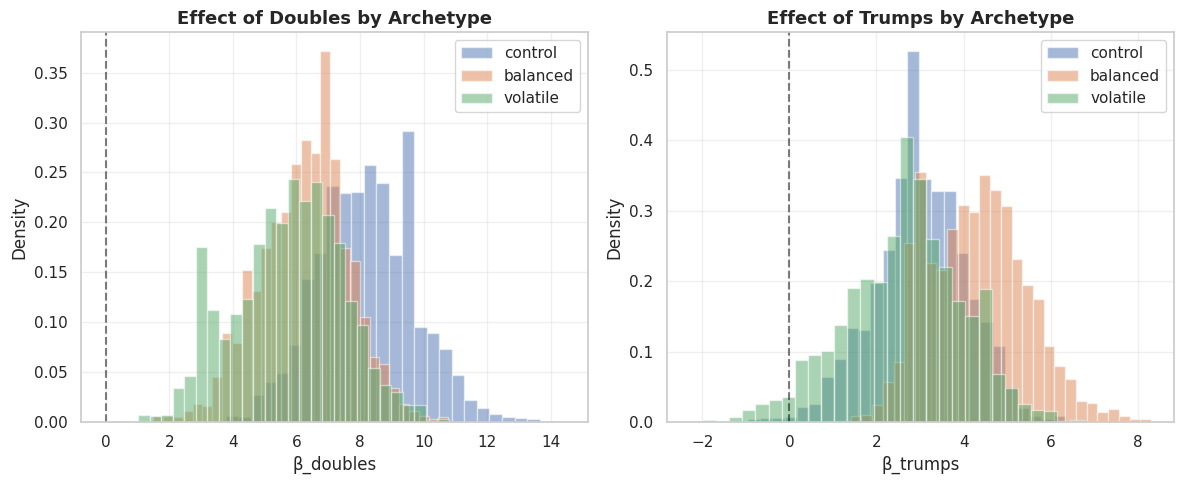

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: β_doubles by archetype
ax = axes[0]
for i, arch in enumerate(['control', 'balanced', 'volatile']):
    bd = trace_hier.posterior['beta_doubles'].values[:, :, i].flatten()
    ax.hist(bd, bins=30, alpha=0.5, label=arch, density=True)
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('β_doubles', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Effect of Doubles by Archetype', fontsize=13, fontweight='bold')
ax.legend()

# Plot 2: β_trumps by archetype
ax = axes[1]
for i, arch in enumerate(['control', 'balanced', 'volatile']):
    bt = trace_hier.posterior['beta_trumps'].values[:, :, i].flatten()
    ax.hist(bt, bins=30, alpha=0.5, label=arch, density=True)
ax.axvline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('β_trumps', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Effect of Trumps by Archetype', fontsize=13, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../../results/figures/19d_hierarchical_archetype.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Key Insights

In [9]:
print("\n" + "="*60)
print("KEY INSIGHTS: Hierarchical Model by Archetype")
print("="*60)

# Extract coefficients
bd_control = trace_hier.posterior['beta_doubles'].values[:, :, 0].flatten()
bd_volatile = trace_hier.posterior['beta_doubles'].values[:, :, 2].flatten()

print(f"\n1. DOUBLES EFFECT BY ARCHETYPE:")
print(f"   Control hands: β = {bd_control.mean():.1f}")
print(f"   Volatile hands: β = {bd_volatile.mean():.1f}")

# Test difference
diff = bd_control - bd_volatile
prob_higher = (diff > 0).mean()
print(f"\n2. DIFFERENCE TEST:")
print(f"   P(β_control > β_volatile) = {prob_higher:.1%}")
print(f"   Mean difference: {diff.mean():.2f}")

print(f"\n3. MODEL COMPARISON:")
print(f"   See LOO comparison above")

print(f"\n4. INTERPRETATION:")
if prob_higher > 0.9:
    print(f"   Doubles ARE more valuable in control hands")
elif prob_higher < 0.1:
    print(f"   Doubles are LESS valuable in control hands")
else:
    print(f"   No clear difference between archetypes (overlapping posteriors)")


KEY INSIGHTS: Hierarchical Model by Archetype

1. DOUBLES EFFECT BY ARCHETYPE:
   Control hands: β = 8.2
   Volatile hands: β = 5.7

2. DIFFERENCE TEST:
   P(β_control > β_volatile) = 86.1%
   Mean difference: 2.47

3. MODEL COMPARISON:
   See LOO comparison above

4. INTERPRETATION:
   No clear difference between archetypes (overlapping posteriors)


## 7. Save Results

In [10]:
# Save coefficient summaries
results = []
for i, arch in enumerate(['control', 'balanced', 'volatile']):
    bd = trace_hier.posterior['beta_doubles'].values[:, :, i].flatten()
    bt = trace_hier.posterior['beta_trumps'].values[:, :, i].flatten()
    results.append({
        'archetype': arch,
        'beta_doubles_mean': bd.mean(),
        'beta_doubles_ci_low': np.percentile(bd, 2.5),
        'beta_doubles_ci_high': np.percentile(bd, 97.5),
        'beta_trumps_mean': bt.mean(),
        'beta_trumps_ci_low': np.percentile(bt, 2.5),
        'beta_trumps_ci_high': np.percentile(bt, 97.5),
    })

results_df = pd.DataFrame(results)
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/19d_hierarchical_archetype.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved coefficients to {output_path}")
print(results_df)

Saved coefficients to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/19d_hierarchical_archetype.csv
  archetype  beta_doubles_mean  beta_doubles_ci_low  beta_doubles_ci_high  \
0   control           8.207893             5.274443             11.196688   
1  balanced           6.259090             3.558738              8.909822   
2  volatile           5.736710             2.597744              8.923054   

   beta_trumps_mean  beta_trumps_ci_low  beta_trumps_ci_high  
0          2.999398            0.826119             4.956623  
1          4.290655            2.386811             6.593484  
2          2.655579           -0.244613             5.083466  


## Key Findings

### Hierarchical Model Results

1. **Archetype-specific effects**: β_doubles and β_trumps vary by hand type

2. **Control vs volatile**: Test whether doubles worth more in control hands

3. **Model comparison**: LOO compares pooled vs hierarchical

### Output Files

- `results/tables/19d_hierarchical_archetype.csv` - Coefficients by archetype
- `results/figures/19d_hierarchical_archetype.png` - Posterior comparisons